In [1]:
import collections
import pandas as pd
import numpy as np

import pylab
import calendar
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

In [63]:
train = pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"])
print("train:",train.shape)
properties = pd.read_csv('properties_2016.csv')
print("properties:",properties.shape)

train: (90275, 3)
properties: (2985217, 58)


In [96]:
merged = pd.merge(train,properties,on="parcelid",how="left")
merged = merged.drop("transactiondate",axis = 1)
merged.head(5).transpose()

,0,1,2,3,4
parcelid,11016594,14366692,12098116,12643413,14432541
logerror,0.0276,-0.1684,-0.004,0.0218,-0.005
airconditioningtypeid,1,NaN,1,1,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,2,3.5,3,2,2.5
bedroomcnt,3,4,2,2,4
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4,4,NaN
calculatedbathnbr,2,3.5,3,2,2.5


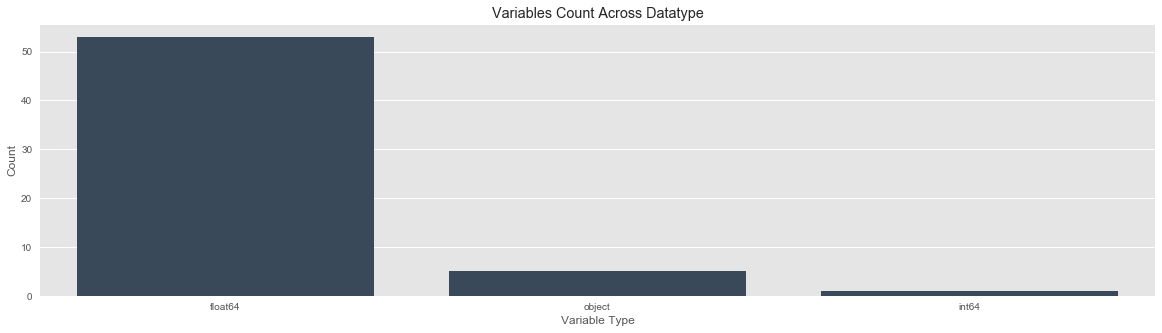

In [13]:
dataTypeDf = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax,color="#34495e")
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

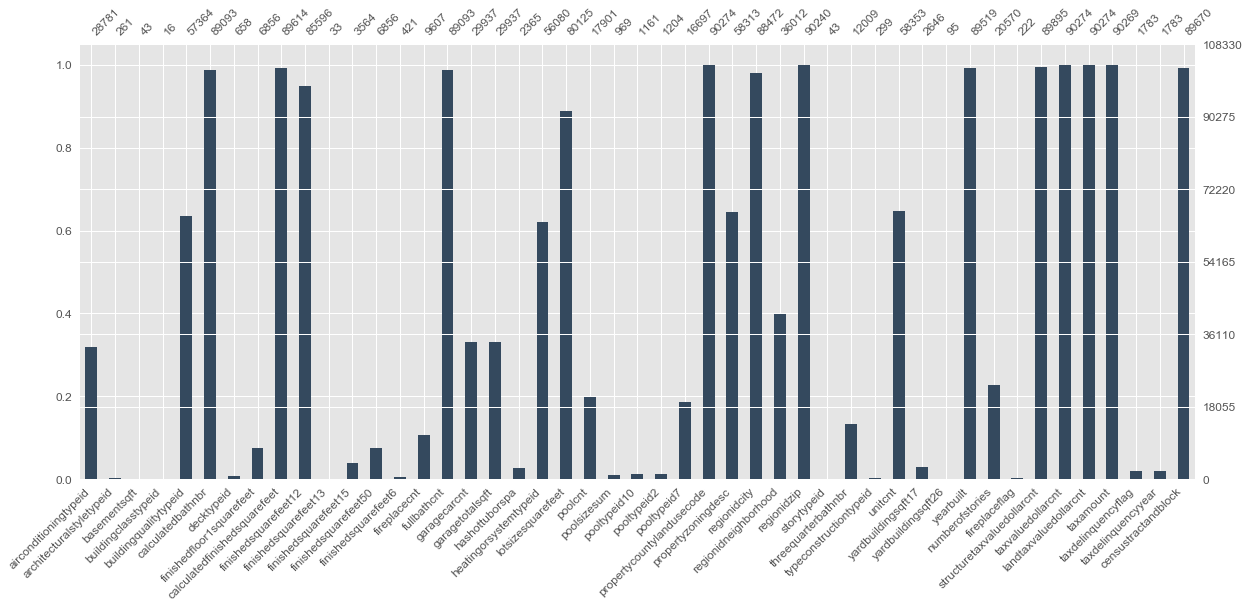

In [14]:
# Missing Value Analysis
missingValueColumns = merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missingValueColumns],\
            figsize=(20,8),color="#34495e",fontsize=12,labels=True,)

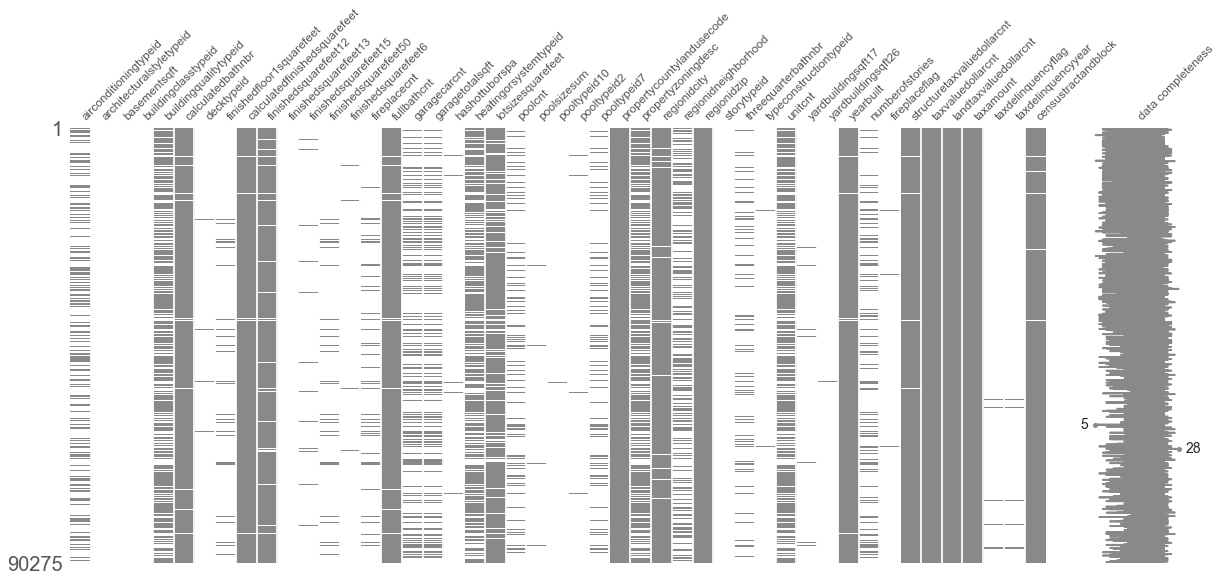

In [15]:
msno.matrix(merged[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(137/255,137/255, 139/255),fontsize=12,sparkline=True,labels=True)

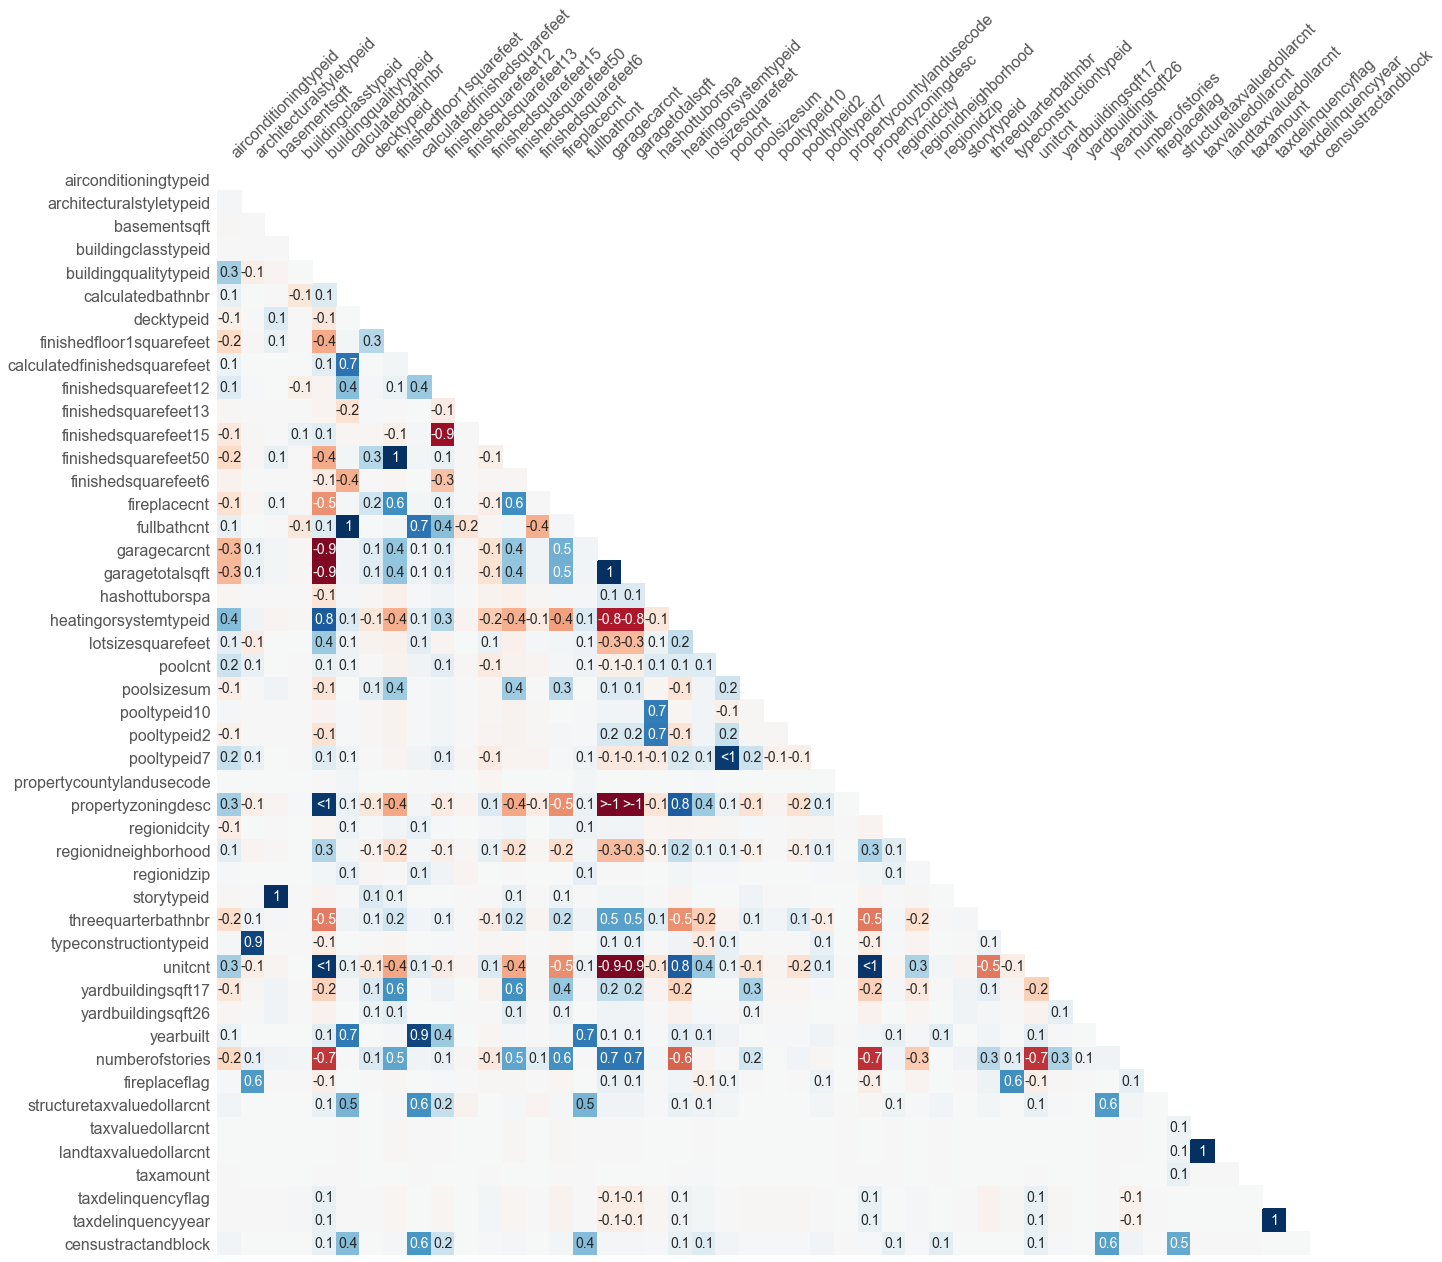

In [16]:
msno.heatmap(merged[missingValueColumns],figsize=(20,20))

In [97]:
# Data Imputation
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.feature_selection import VarianceThreshold

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of categorical feature are imputed with the most frequent value
        in column.

        Columns of numerical feature are imputed with median of column.

        """

    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
                               if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
                              index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

mergedFilterd = pd.DataFrame(DataFrameImputer().fit_transform(merged))

In [98]:
num_cols = mergedFilterd._get_numeric_data().columns
cate_cols = list(set(mergedFilterd.columns) - set(num_cols))
mergedFilterd = mergedFilterd.drop(cate_cols, axis=1)
Y = mergedFilterd['logerror']

scaler = preprocessing.StandardScaler().fit(mergedFilterd)
mergedFilterd = pd.DataFrame(scaler.transform(mergedFilterd))
mergedFilterd.columns = num_cols

mergedFilterd.head(3).transpose()

,0,1,2
parcelid,-0.785811,0.551822,-0.353979
logerror,0.100217,-1.116585,-0.095961
airconditioningtypeid,-0.151158,-0.151158,-0.151158
architecturalstyletypeid,-0.004543,-0.004543,-0.004543
basementsqft,-0.004805,-0.004805,-0.004805
bathroomcnt,-0.278287,1.215342,0.717466
bedroomcnt,-0.027558,0.837173,-0.892289
buildingclasstypeid,0.000000,0.000000,0.000000
buildingqualitytypeid,-1.254327,0.547515,-1.254327
calculatedbathnbr,-0.314479,1.231288,0.716033


In [100]:
# Top Features Selection
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings

train_y = Y.values
train_X = mergedFilterd.drop(["parcelid", "logerror"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

mean of importance: 176.0731707317073


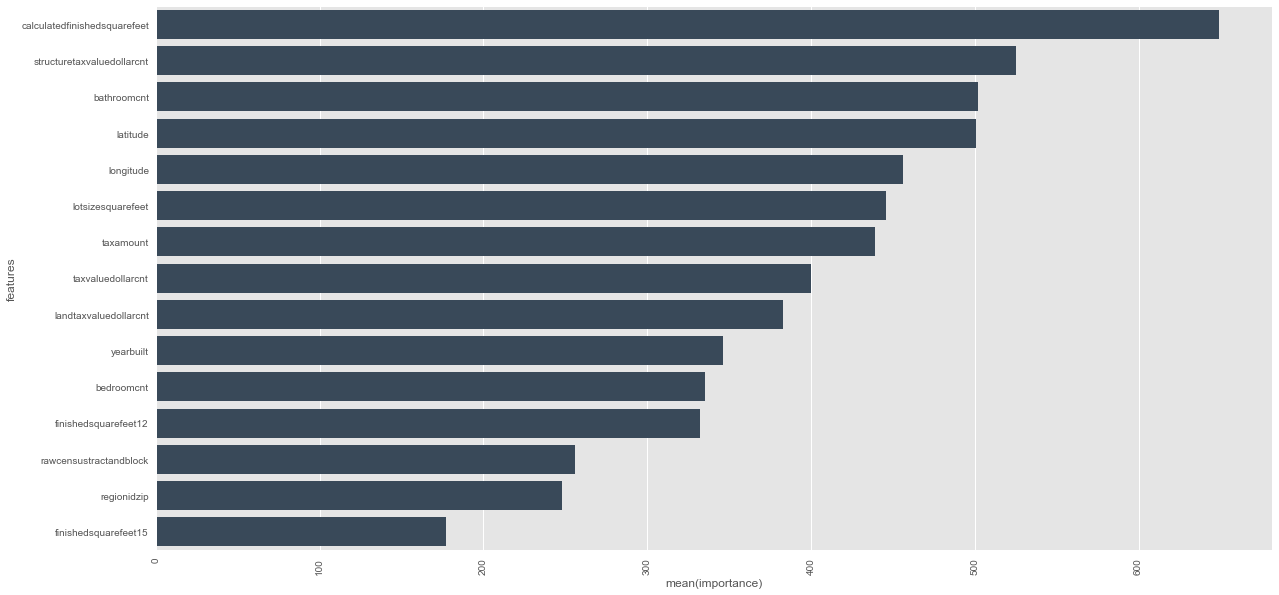

In [101]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")
importance_mean = np.mean(features['importance'])
print("mean of importance:",importance_mean)

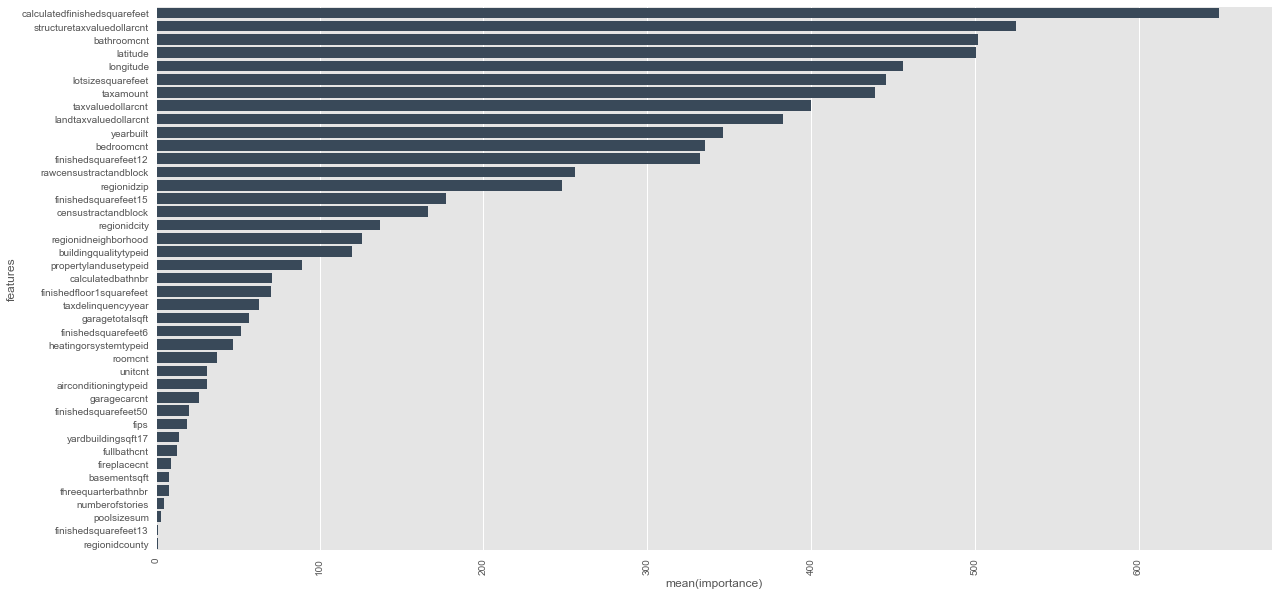

In [102]:
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")

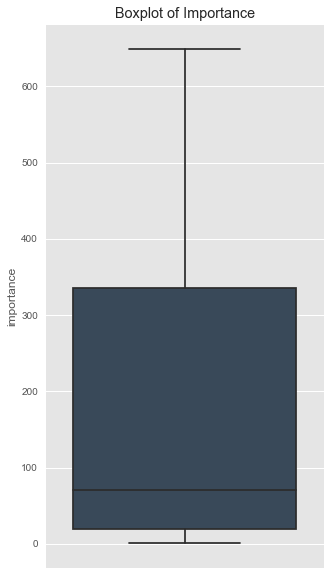

In [103]:
features['label'] = [0] * features.shape[0]
fig,ax= plt.subplots()
fig.set_size_inches(5,10)
plt.setp( ax.get_xticklabels(), visible=False)
sn.boxplot(x="label", y="importance", data=features,ax=ax,color="#34495e")
ax.set(ylabel='importance',xlabel="",title="Boxplot of Importance")

In [104]:
feature_nums = features.shape[0]
print("feature counts:",feature_nums)
cumulative_importance = np.zeros((features.shape[0],1))
cumulative_importance[0] = features['importance'][0]
for i in range(1,features.shape[0]):
    cumulative_importance[i] = cumulative_importance[i-1] + features['importance'][i]
cumulative_importance /= np.sum(features['importance'])
features['cumulative_importance'] = cumulative_importance
features

feature counts: 41


,features,importance,label,cumulative_importance
0,calculatedfinishedsquarefeet,649,0,0.089902
5,structuretaxvaluedollarcnt,525,0,0.151683
10,bathroomcnt,502,0,0.212495
6,latitude,501,0,0.260424
9,longitude,456,0,0.269151
1,lotsizesquarefeet,446,0,0.341876
2,taxamount,439,0,0.411276
29,taxvaluedollarcnt,400,0,0.421111
13,landtaxvaluedollarcnt,383,0,0.440089
3,yearbuilt,346,0,0.503255


In [105]:
cumulative_threshold = 0.9
topFeatureIndex = np.sum(features['cumulative_importance'] < cumulative_threshold) + 1
topFeatures = features['features'][:topFeatureIndex].tolist()
print('top features count:',len(topFeatures))
topFeatures

top features count: 30


['calculatedfinishedsquarefeet',
 'structuretaxvaluedollarcnt',
 'bathroomcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'taxamount',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'yearbuilt',
 'bedroomcnt',
 'finishedsquarefeet12',
 'rawcensustractandblock',
 'regionidzip',
 'finishedsquarefeet15',
 'censustractandblock',
 'regionidcity',
 'regionidneighborhood',
 'buildingqualitytypeid',
 'propertylandusetypeid',
 'calculatedbathnbr',
 'finishedfloor1squarefeet',
 'taxdelinquencyyear',
 'garagetotalsqft',
 'finishedsquarefeet6',
 'heatingorsystemtypeid',
 'roomcnt',
 'unitcnt',
 'airconditioningtypeid',
 'garagecarcnt']

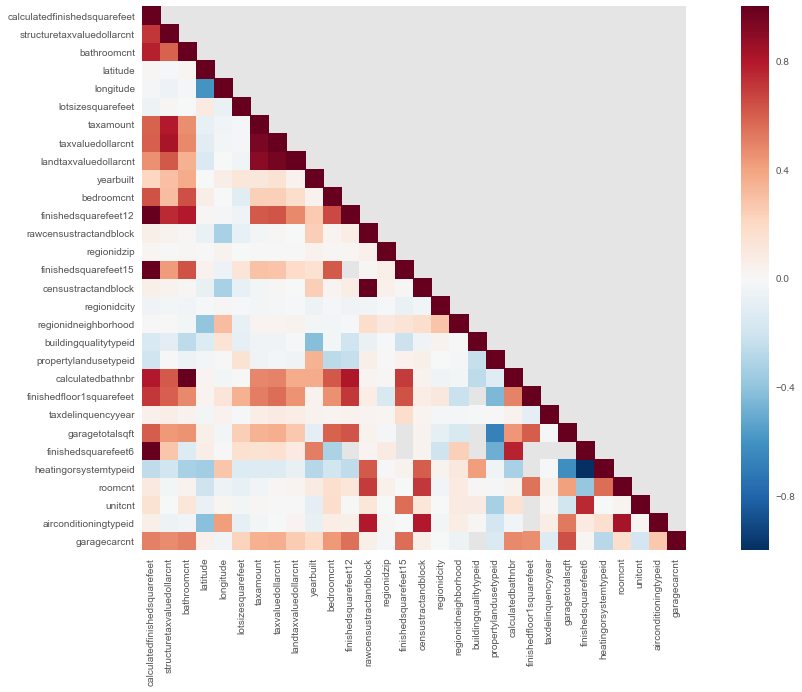

In [106]:
# Correlation Analysis
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

In [75]:
# modeling
import math
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops
np.random.seed(1)

In [107]:
# split data set to training set and test set

X = mergedFilterd[topFeatures]
print("X shape:", X.shape)
# Y = mergedFilterd['logerror']
print("Y shape:", Y.shape)
randIndex = np.random.permutation(X.shape[0])

X_train = np.array(X.iloc[randIndex[:-10000],:])
X_train = X_train.reshape(X_train.shape).T
print('X_train shape:',X_train.shape)

Y_train = np.array(Y.iloc[randIndex[:-10000]])
Y_train = Y_train.reshape(Y_train.shape[0],1).T
print('Y_train shape:',Y_train.shape)

X_test =np.array(X.iloc[randIndex[-10000:],:])
X_test = X_test.reshape(X_test.shape).T
print('X_test shape:',X_test.shape)

Y_test = np.array(Y.iloc[randIndex[-10000:]])
Y_test = Y_test.reshape(Y_test.shape[0],1).T
print('Y_test shape:',Y_test.shape)

X shape: (90275, 30)
Y shape: (90275,)
X_train shape: (30, 80275)
Y_train shape: (1, 80275)
X_test shape: (30, 10000)
Y_test shape: (1, 10000)


In [108]:
X.head().transpose()

,0,1,2,3,4
calculatedfinishedsquarefeet,-0.094575,0.531394,0.481662,-1.008121,0.553016
structuretaxvaluedollarcnt,-0.273761,0.798074,-0.564880,-0.040117,-0.049432
bathroomcnt,-0.278287,1.215342,0.717466,-0.278287,0.219590
latitude,1.040064,-1.272968,0.494034,-0.942055,-1.961655
longitude,-0.803291,1.445675,0.066102,-0.305411,1.382786
lotsizesquarefeet,-0.166420,-0.200237,-0.132516,0.384848,-0.179720
taxamount,0.109964,0.609646,0.804343,-0.429201,-0.072371
taxvaluedollarcnt,-0.175717,0.230425,-0.608720,-0.383492,-0.041667
landtaxvaluedollarcnt,-0.102171,-0.098038,-0.550380,-0.511803,-0.033352
yearbuilt,-0.403362,1.920843,-1.206269,0.779870,0.526320


In [78]:
# create placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of number of training examples: 58386
    n_y -- scalar, number of classes: 1
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32,shape=(n_x,None))
    Y = tf.placeholder(tf.float32,shape=(n_y,None))
    
    return X, Y

In [172]:
# Initializing the parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
#     tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [100,30], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [100,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [50,100], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [50,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2,50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [2,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [80]:
# Forward propagation in tensorflow

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last SOFTMAX unit
    """
    
    # keep_prob = tf.Variable(0.5,tf.float32)
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1,X),b1)                                         
    A1 = tf.nn.relu(Z1)#     drop_A1 = tf.nn.dropout(A1, keep_prob)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              
    A2 = tf.nn.relu(Z2) #     drop_A2 = tf.nn.dropout(A2, keep_prob)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                              
    
    return Z3

In [81]:
# Compute cost

def compute_cost(Z3, Y):
# def compute_cost(Z3, Y, parameters):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last SIGMOID unit), of shape (1, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
#     W1 = parameters['W1']
#     W2 = parameters['W2']
#     W3 = parameters['W3']
    
#     logits = tf.transpose(Z3)
#     labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.square(Z3 - Y))
    
#     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)) \
#             + 0.0001 * tf.nn.l2_loss(W1) + 0.0001 * tf.nn.l2_loss(W2) + 0.0001 * tf.nn.l2_loss(W3)
    
    return cost

In [83]:
# random mini batches

def random_mini_batches(X, Y, mini_batch_size = 2048, seed = None):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    if not seed is None:
        np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [84]:
# Forward propagation for predict

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [110]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [30, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [133]:
# Building the model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, learning_rate_decay = None,
          num_epochs = 5000, minibatch_size = 2048, print_cost = True, pre_parameters = None):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = tf.reduce_mean(tf.abs(Z3 - Y))
    
    # learning rate decay
    if not learning_rate_decay is None:
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate, global_step, 100000, learning_rate_decay, staircase=True)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
#     optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    parameters = pre_parameters

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0 and epoch > 50:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
#         correct_prediction = tf.square(Z3 - Y)

        # Calculate accuracy on the test set
        _ , train_cost = sess.run((optimizer,cost), feed_dict={X: X_train, Y: Y_train})
        _ , test_cost = sess.run((optimizer,cost), feed_dict={X: X_test, Y: Y_test})

        print ("Train Cost:", train_cost )
        print ("Test Cost:", test_cost )
        
        return parameters

Cost after epoch 0: 0.257714
Cost after epoch 100: 0.070123
Cost after epoch 200: 0.068657
Cost after epoch 300: 0.068673
Cost after epoch 400: 0.067697


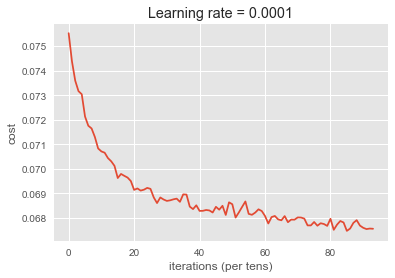

Parameters have been trained!
Train Cost: 0.0658616
Test Cost: 0.0693484


In [123]:
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.00001, num_epochs = 500)

Cost after epoch 0: 0.316171
Cost after epoch 100: 0.074669
Cost after epoch 200: 0.070954
Cost after epoch 300: 0.070248
Cost after epoch 400: 0.068994
Cost after epoch 500: 0.068680
Cost after epoch 600: 0.068746
Cost after epoch 700: 0.068386
Cost after epoch 800: 0.068426
Cost after epoch 900: 0.068341
Cost after epoch 1000: 0.068090
Cost after epoch 1100: 0.067815
Cost after epoch 1200: 0.067614
Cost after epoch 1300: 0.067663
Cost after epoch 1400: 0.067701
Cost after epoch 1500: 0.067376
Cost after epoch 1600: 0.067389
Cost after epoch 1700: 0.067688
Cost after epoch 1800: 0.067306
Cost after epoch 1900: 0.067284


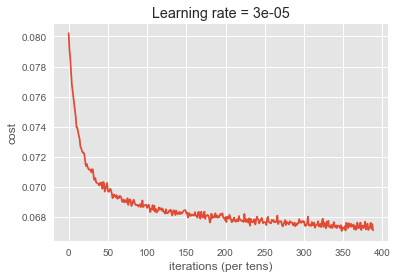

Parameters have been trained!
Train Cost: 0.0655562
Test Cost: 0.0693497


In [126]:
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.00003, num_epochs = 2000)

Cost after epoch 0: 0.316171
Cost after epoch 100: 0.074669
Cost after epoch 200: 0.070954


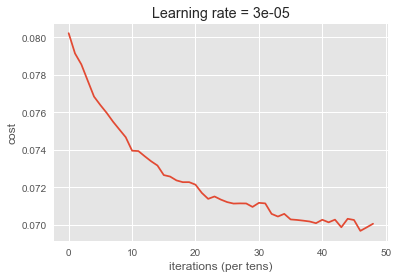

Parameters have been trained!
Train Cost: 0.0679917
Test Cost: 0.0703347


In [136]:
parameters1 = model(X_train, Y_train, X_test, Y_test, learning_rate=0.00003, num_epochs = 300)

In [1]:
Bayes_Cost = 0.0636602
Train_Cost = 0.0658616
Test_Cost = 0.0693484
Avoidable_Bias = Train_Cost - Bayes_Cost
print("Avoidable_Bias:",Avoidable_Bias)
Variance = Test_Cost - Train_Cost
print("Variance:",Variance)

Avoidable_Bias: 0.002201400000000006
Variance: 0.0034867999999999982
